In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-stress-prediction/Stress.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.models import Sequential
import re
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
# Загрузка данных
df = pd.read_csv("/kaggle/input/human-stress-prediction/Stress.csv")

In [4]:
df.head()

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005


In [5]:
df.isna().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

In [6]:
df=df.drop(columns=['post_id','social_timestamp'])
df.head()

,subreddit,sentence_range,text,label,confidence
0,ptsd,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8
1,assistance,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0
2,ptsd,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8
3,relationships,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6
4,survivorsofabuse,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8


In [7]:
# Функция для очистки текста
def clean_text(text):
    # Удаление специальных символов и цифр
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
# Предобработка текста
df['text'] = df['text'].apply(clean_text)

In [9]:
df.head()

,subreddit,sentence_range,text,label,confidence
0,ptsd,"(15, 20)",he said he had not felt that way before sugget...,1,0.8
1,assistance,"(0, 5)",hey there rassistance not sure if this is the ...,0,1.0
2,ptsd,"(15, 20)",my mom then hit me with the newspaper and it s...,1,0.8
3,relationships,"[5, 10]",until i met my new boyfriend he is amazing he ...,1,0.6
4,survivorsofabuse,"[0, 5]",october is domestic violence awareness month a...,1,0.8


In [10]:
# Создаем функцию для подсчета слов в тексте
def get_word_count(text):
    return len(str(text).split())


In [11]:
# Добавляем новые признаки
df['word_count'] = df['text'].apply(get_word_count)
df['post_length'] = df['text'].str.len()
df=df.drop(columns=['sentence_range'])

In [12]:
df.head()

,subreddit,text,label,confidence,word_count,post_length
0,ptsd,he said he had not felt that way before sugget...,1,0.8,112,543
1,assistance,hey there rassistance not sure if this is the ...,0,1.0,106,568
2,ptsd,my mom then hit me with the newspaper and it s...,1,0.8,165,825
3,relationships,until i met my new boyfriend he is amazing he ...,1,0.6,273,1244
4,survivorsofabuse,october is domestic violence awareness month a...,1,0.8,89,518


In [13]:
# Статистический отчет
stats_report = pd.DataFrame({
    'Метрика': [
        'Всего постов',
        'Посты со стрессом',
        'Посты без стресса',
        'Процент стресса',
        'Среднее количество слов в посте',
        'Максимальное количество слов',
        'Минимальное количество слов',
        'Количество уникальных сабреддитов'
    ],
    'Значение': [
        len(df),
        len(df[df['label'] == 1]),
        len(df[df['label'] == 0]),
        f"{(len(df[df['label'] == 1]) / len(df) * 100):.2f}%",
        f"{df['word_count'].mean():.2f}",
        df['word_count'].max(),
        df['word_count'].min(),
        len(df['subreddit'].unique())
    ]
})

print("\nСтатистический отчет:")
print(stats_report.to_string(index=False))


Статистический отчет:
                          Метрика Значение
                     Всего постов     2838
                Посты со стрессом     1488
                Посты без стресса     1350
                  Процент стресса   52.43%
  Среднее количество слов в посте    84.85
     Максимальное количество слов      310
      Минимальное количество слов        1
Количество уникальных сабреддитов       10


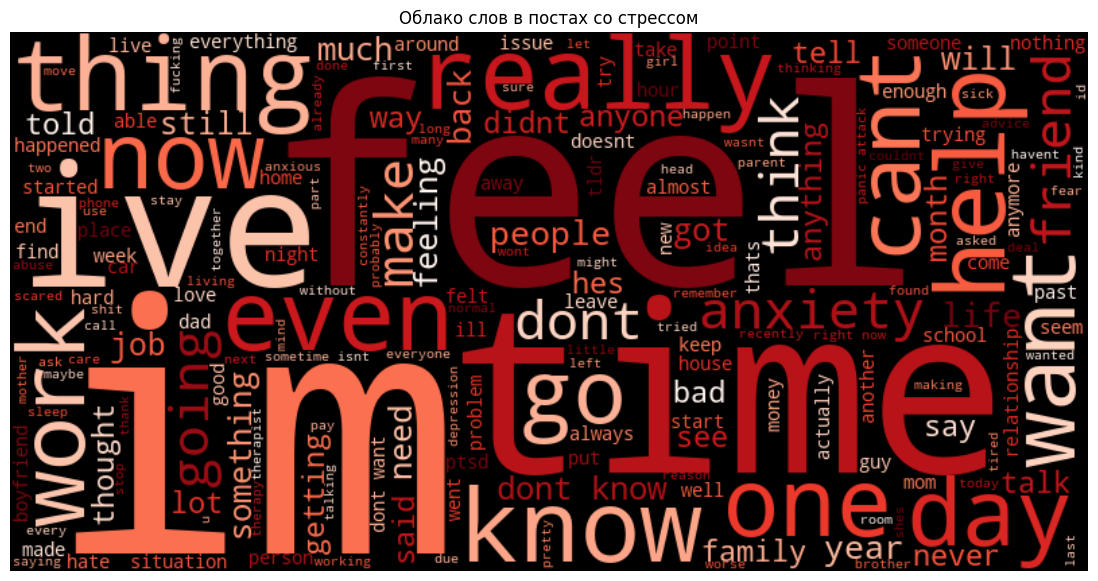

In [14]:
#облако слов для постов со стрессом
stress_texts = df[df['label'] == 1]['text'].str.cat(sep=' ')
stress_texts = re.sub(r'[^\w\s]', '', stress_texts.lower())

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='black',
    colormap='Reds'
).generate(stress_texts)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов в постах со стрессом')
plt.show()

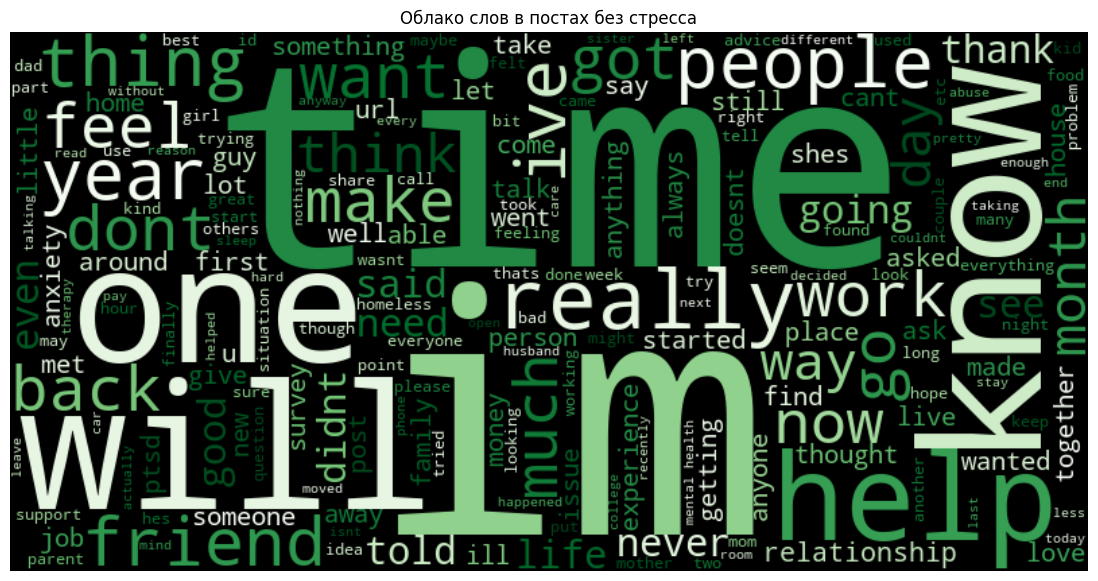

In [15]:
#облако слов для постов со стрессом
stress_texts = df[df['label'] == 0]['text'].str.cat(sep=' ')
stress_texts = re.sub(r'[^\w\s]', '', stress_texts.lower())

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='black',
    colormap='Greens'
).generate(stress_texts)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов в постах без стресса')
plt.show()

In [16]:
# Подготовка данных для модели
texts = df['text'].values
labels = df['label'].values

In [17]:
# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [18]:
# Токенизация текста
max_words = 10000  # максимальное количество слов для словаря
max_len = 200      # максимальная длина последовательности

In [19]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [20]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [21]:
# Padding последовательностей
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [22]:
# Создание модели с использованием функционального API
def create_model(vocab_size, max_len):
    model = Sequential([
        Embedding(vocab_size, 100),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(16, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [23]:
# Создание модели
model = create_model(max_words, max_len)

In [24]:
# Добавляем колбэки для лучшего обучения
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6
    )
]

In [25]:
# Компиляция модели
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [26]:
# Вывод архитектуры модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Обучение модели
history = model.fit(
    X_train_pad, 
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.5536 - loss: 0.6869 - val_accuracy: 0.6960 - val_loss: 0.5931 - learning_rate: 0.0010
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 136ms/step - accuracy: 0.7762 - loss: 0.5049 - val_accuracy: 0.6564 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.8308 - loss: 0.4338 - val_accuracy: 0.7004 - val_loss: 0.5915 - learning_rate: 0.0010
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9343 - loss: 0.2382 - val_accuracy: 0.7137 - val_loss: 0.7257 - learning_rate: 0.0010
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.9706 - loss: 0.1239 - val_accuracy: 0.7269 - val_loss: 0.9444 - learning_rate: 0.0010


In [28]:
# Оценка модели
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=0)
print(f'\nТочность на обучающей выборке: {accuracy:.4f}')



Точность на обучающей выборке: 0.8907


In [29]:
# Оценка модели
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'\nТочность на тестовой выборке: {accuracy:.4f}')


Точность на тестовой выборке: 0.6919


In [30]:
# Предсказание на тестовой выборке
y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [31]:
# Вывод метрик
print('\nОтчет по классификации:')
print(classification_report(y_test, y_pred_classes))


Отчет по классификации:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       263
           1       0.72      0.70      0.71       305

    accuracy                           0.69       568
   macro avg       0.69      0.69      0.69       568
weighted avg       0.69      0.69      0.69       568



In [32]:
print('\nМатрица ошибок:')
print(confusion_matrix(y_test, y_pred_classes))


Матрица ошибок:
[[178  85]
 [ 90 215]]


In [33]:
# Функция для предсказания стресса в новом тексте
def predict_stress(text):
    # Очистка текста
    cleaned = clean_text(text)
    # Преобразование в последовательность
    sequence = tokenizer.texts_to_sequences([cleaned])
    # Padding
    padded = pad_sequences(sequence, maxlen=max_len)
    # Предсказание
    prediction = model.predict(padded)[0][0]
    return {
        'stress_probability': float(prediction),
        'is_stressed': bool(prediction > 0.5)
    }


In [34]:
# Пример использования
sample_text = "I feel really anxious and overwhelmed with all these deadlines"
result = predict_stress(sample_text)
print(f'\nПример предсказания для текста: "{sample_text}"')
print(f'Вероятность стресса: {result["stress_probability"]:.4f}')
print(f'Наличие стресса: {"Да" if result["is_stressed"] else "Нет"}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Пример предсказания для текста: "I feel really anxious and overwhelmed with all these deadlines"
Вероятность стресса: 0.0506
Наличие стресса: Нет
